# Note 01. DQN algorithm for Cartpole environment
- Class Date : 23. 10. 20.

In this example, we will implement Deep Q-Learning (DQN) for Cartpole environment.

**Q-Learning** is a foundational algorithm for reinforcement learning. During Q-Learning, agent builds a table which maps each state-action pair to its corresponding Q-value  (Vanilla Q-Learning). While this algorithm is simple and powerful, it runs into several problems.
- The environment is usually composed of continuous numbers, resulting in an infinite number of states.
- Vanilla Q-Learning primarily deals only with discrete actions.
Depp Q-Learning is introduced to handle continuous actions and states. In Deep Q-Learning, a neural network maps input states to (action, Q-value) pairs.

**Cartpole environment** is also one of the most well known classic environment for reinforcement learning.
A pole is attatched to a cart which moves along a frictionless track.
The agent has to control the cart left or right to prevent the pole from falling off the cart.
- The observation from the environment is a 4D vector representing the position and velocity of the cart, and the angle and angular velocity of the pole.
- The agent can control the system by taking one of 2 actions: push the cart right (+1) or left (-1).
- A reward 1 is provided for every timestep that the pole remains upright.
- If one of the following condition is met, the episode ends.
    - The pole tips over some angle limit.
    - The cart moves outside of the world edges.
    - 200 time steps pass.


As usual, let's start with importing libraries!

In [2]:
import random
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import torch
from torch.distributions import Categorical
import torch.nn as nn
import torch.nn.functional as F

import gym                                    # this is for RL environment (https://gym.openai.com/)
from collections import deque               # this simplifies the implementation of the replay buffer


# For reproducibility, set seed for random functions.
SEED = 123
torch.manual_seed(SEED)
random.seed(SEED)

We need a bunch of stuff for visualization (as we are running on server without a physical display!)

In [3]:
!apt-get install -y xvfb python-opengl ffmpeg
!pip install -U colabgymrender
!pip install imageio==2.4.1
!pip install moviepy==0.2.3.5

import glob
import io
import base64
from IPython.display import HTML, clear_output
from IPython import display as ipythondisplay
from colabgymrender.recorder import Recorder



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
  Preparing metadata (setup.py) ... done
  Created wheel for colabgymrender: filename=colabgymrender-1.1.0-py3-none-any.whl size=3114 sha256=8cde38396763de630cfd9bc7be017f48a3e40dc7cdc6eb24d373739fd4ba0608
  Stored in directory: /root/.cache/pip/wheels/13/62/63/7b3acfb684dd3d665d7fc1d213427b136205a222389767e295
Successfully built colabgymrender
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 35.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303886 sha256=69249e15b02fc36ffb9350b9428b3d4d3316725dd5dac67f551009f4f621fc07
  Stored in directory: /root/.cache/pip/wheels/96/5d/ce/bdbdb04744dac03906336eb0d01ff1e222061d3419c55c55f9
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.5
    Uninstalling imageio-2

  from scipy.ndimage.filters import sobel



Let's specify the environment.
We are going to use CartPole from OPENAI (https://gym.openai.com/)

In [4]:
ENV_NAME = "CartPole-v1"

env = gym.make(ENV_NAME)
directory = './video'
env = Recorder(env, directory)

observation = env.reset()
terminal = False
while not terminal:
  action = env.action_space.sample()
  observation, reward, terminal, info = env.step(action)

env.play()

  and should_run_async(code)

  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  result = np.fromstring(s, dtype='uint8')



Let's define our Q-network.

In [5]:
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(4, 48)     # four-dimensional observation ([position of cart, velocity of cart, angle of pole, rotation rate of pole])
        self.fc1 = nn.Linear(48, 64)   # hidden layer
        self.fc2 = nn.Linear(64, 2)    # two possible actions (left-right)

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

Define a function for updating our Q-network.

In [6]:
def update_Q():

    loss = 0
    for state, action, state_next, reward, done in random.sample(history, min(32, len(history))):
        with torch.no_grad():
            if done:
                target = reward
            else:
                target = reward + discount * torch.max(Q_target(state_next))

        loss = loss + (target - Q(state)[action])**2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Here are our hyper-parameters.

In [7]:
buffer_size = 1000000   # size of replay buffer
discount = 0.99         # discount factor gamma
max_time_steps = 200    # maximum episode length
target_interval = 1000  # we will update target network every THIS updates


reward_recent_history = deque(maxlen=30)  # for computing average reward over 30 episodes

Here's our replay buffer. deque function makes it very easy to implement :)

In [8]:
history = deque(maxlen=buffer_size) # replay buffer

Let's initialize our networks (Q-network & target network).

In [9]:
# network and optimizer
Q = QNetwork()
optimizer = torch.optim.Adam(Q.parameters(), lr=0.001)

# target network
Q_target = QNetwork()

Test the performance of the untrained network!

In [10]:
def plt_history():
    clear_output(True)
    plt.figure(figsize=[16, 9])
    plt.subplot(1, 2, 1)
    plt.title("Reward history")
    plt.plot(reward_history)
    plt.grid()

    plt.show()

  and should_run_async(code)



Let's start training!

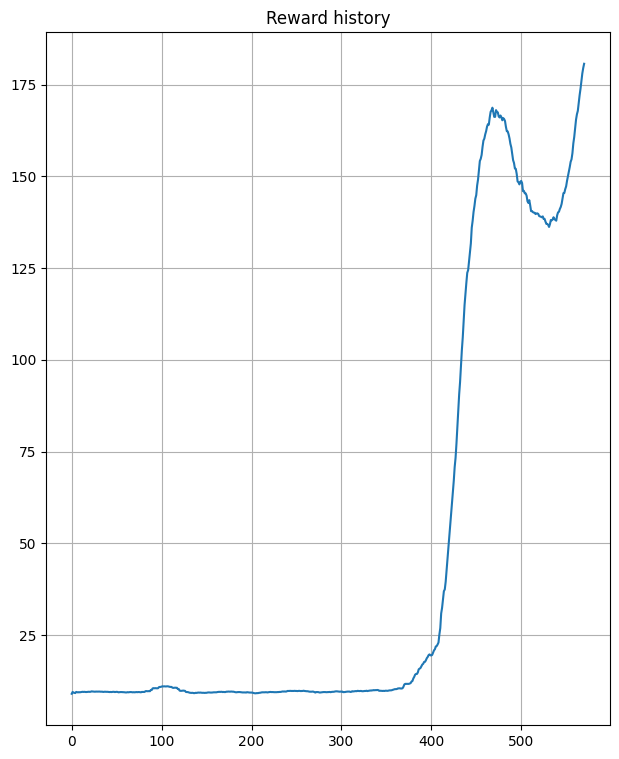

Early stopping as the exit condition is met.


In [11]:
ENV_NAME = "CartPole-v1"

env = gym.make(ENV_NAME)

target_counter = 0      # counter initialization
reward_history = []

# training
for episode in range(1000):
    # sum of accumulated rewards
    rewards = 0

    # get initial observation
    observation = env.reset()
    state = torch.tensor(observation, dtype=torch.float32)

    # loop until an episode ends
    for t in range(1, max_time_steps + 1):
        # display current environment
        #env.render()

        # epsilon greedy policy for current observation
        with torch.no_grad():
            if random.random() < 0.01:
                action = env.action_space.sample()
            else:
                action = torch.argmax(Q(state)).item()

        # proceed one step (in the environment)
        observation_next, reward, done, info = env.step(action)
        state_next = torch.tensor(observation_next, dtype=torch.float32)

        # collect reward
        rewards = rewards + reward

        # collect a transition, put it in the replay buffer
        history.append([state, action, state_next, reward, done]) # SASR is added to the buffer

        # perform update
        update_Q()

        # update target network
        target_counter = target_counter + 1
        if target_counter % target_interval == 0:
            Q_target.load_state_dict(Q.state_dict())

        if done:
            break

        # pass observation to the next step
        observation = observation_next
        state = state_next

    # compute average reward
    reward_recent_history.append(rewards)
    recent_average_reward = np.mean(reward_recent_history)
    reward_history.append(recent_average_reward)

    if episode%10 == 0:
        plt_history()

    if recent_average_reward > 0.9*max_time_steps:
        print("Early stopping as the exit condition is met.")
        break

env.close()

Let's visualize how trained agent work in the virtual environment!

In [12]:
# TEST (with trained Q-network)
ENV_NAME = "CartPole-v1"

env = gym.make(ENV_NAME)
directory = './video'
env = Recorder(env, directory)

observation = env.reset()
rewards = 0
done = False

while not done:
    state = torch.tensor(observation, dtype=torch.float32)
    action = torch.argmax(Q(state)).item()
    observation, reward, done, info = env.step(action)
    rewards = rewards + reward

    if done:
        break

env.play()

print("Total reward is " + str(rewards) + ".")

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  result = np.fromstring(s, dtype='uint8')



Total reward is 500.0.
